$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/shaigue/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/shaigue/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/shaigue/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


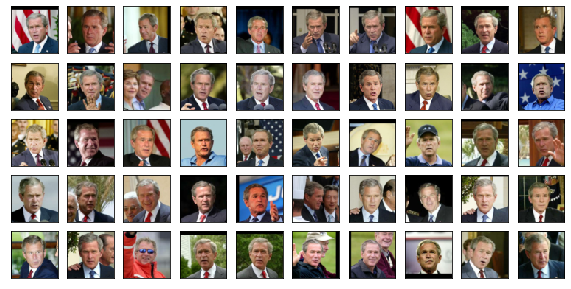

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (features_extractor): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (flattener): Linear(in_features=16384, out_features=1, bias=True)
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (deflattener): Linear(in_features=128, out_features=16384, bias=True)
  (feature_decoder): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (10): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

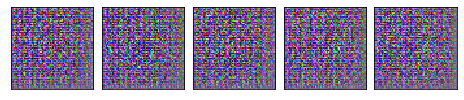

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label']

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 16, 'data_label': <function bin_rand at 0x7fae898d1ea0>, 'label_noise': 0.25, 'discriminator_optimizer': {'type': 'SGD', 'lr': 0.003}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.003}}


**TODO**:
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training.

--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.68it/s]
Discriminator loss: 2.2811968747307274
Generator loss:     1.7649403895415805


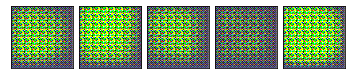

*** Saved checkpoint checkpoints/gan at epoch 1
--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.71it/s]
Discriminator loss: 1.6565479005084318
Generator loss:     1.0217098655069576


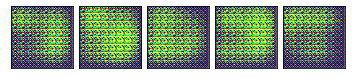

*** Saved checkpoint checkpoints/gan at epoch 2
--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.70it/s]
Discriminator loss: 1.6698100146125345
Generator loss:     0.8262583508211023


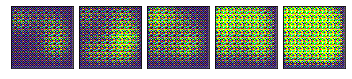

*** Saved checkpoint checkpoints/gan at epoch 3
--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.76it/s]
Discriminator loss: 1.3420502718757181
Generator loss:     0.7579888175515568


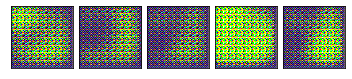

*** Saved checkpoint checkpoints/gan at epoch 4
--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.65it/s]
Discriminator loss: 1.5446437877767227
Generator loss:     0.7493835792821997


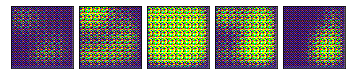

*** Saved checkpoint checkpoints/gan at epoch 5
--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.70it/s]
Discriminator loss: 1.5051819892490612
Generator loss:     0.7397745128940133


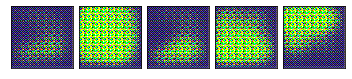

*** Saved checkpoint checkpoints/gan at epoch 6
--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.68it/s]
Discriminator loss: 1.4322014976950252
Generator loss:     0.7012983876116136


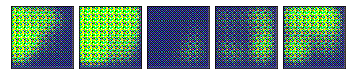

*** Saved checkpoint checkpoints/gan at epoch 7
--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.68it/s]
Discriminator loss: 1.501084888682646
Generator loss:     0.6656287715715521


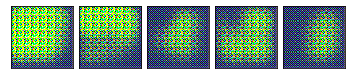

*** Saved checkpoint checkpoints/gan at epoch 8
--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.69it/s]
Discriminator loss: 1.4735296824399162
Generator loss:     0.7309748249895432


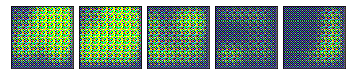

*** Saved checkpoint checkpoints/gan at epoch 9
--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.67it/s]
Discriminator loss: 1.4711008492638082
Generator loss:     0.741583797861548


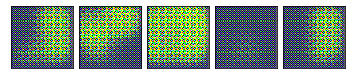

*** Saved checkpoint checkpoints/gan at epoch 10
--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.70it/s]
Discriminator loss: 1.4498378564329708
Generator loss:     0.8035980778581956


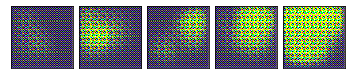

*** Saved checkpoint checkpoints/gan at epoch 11
--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.14it/s]
Discriminator loss: 1.4390855957480038
Generator loss:     0.6708238265093636


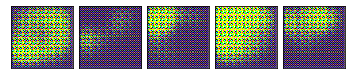

*** Saved checkpoint checkpoints/gan at epoch 12
--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.20it/s]
Discriminator loss: 1.4691942930221558
Generator loss:     0.6505043594276204


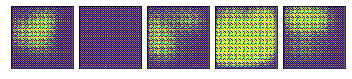

*** Saved checkpoint checkpoints/gan at epoch 13
--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 1.3883856955696554
Generator loss:     0.7444933758062475


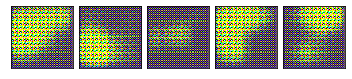

*** Saved checkpoint checkpoints/gan at epoch 14
--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.16it/s]
Discriminator loss: 1.4441982016843908
Generator loss:     0.6290691635187935


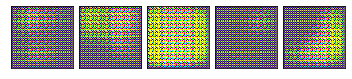

*** Saved checkpoint checkpoints/gan at epoch 15
--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 1.2904575852786793
Generator loss:     0.7248981174300698


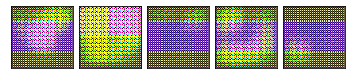

*** Saved checkpoint checkpoints/gan at epoch 16
--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
Discriminator loss: 1.4048050221274881
Generator loss:     0.6728830144685858


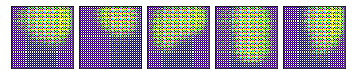

*** Saved checkpoint checkpoints/gan at epoch 17
--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 1.5090778259670032
Generator loss:     0.726832786027123


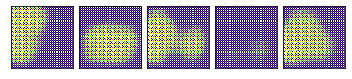

*** Saved checkpoint checkpoints/gan at epoch 18
--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.69it/s]
Discriminator loss: 1.4760238703559427
Generator loss:     0.7086530993966496


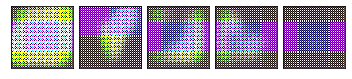

*** Saved checkpoint checkpoints/gan at epoch 19
--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.69it/s]
Discriminator loss: 1.4109007821363562
Generator loss:     0.6699306684381822


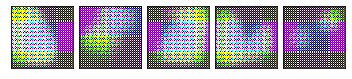

*** Saved checkpoint checkpoints/gan at epoch 20
--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Discriminator loss: 1.4268372549730188
Generator loss:     0.7989158735555761


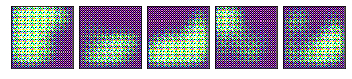

*** Saved checkpoint checkpoints/gan at epoch 21
--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.79it/s]
Discriminator loss: 1.4709534995696123
Generator loss:     0.6988586537978229


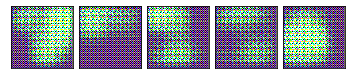

*** Saved checkpoint checkpoints/gan at epoch 22
--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
Discriminator loss: 1.386208548265345
Generator loss:     0.7846291152869954


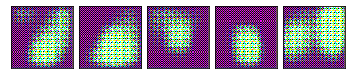

*** Saved checkpoint checkpoints/gan at epoch 23
--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
Discriminator loss: 1.4366798330755794
Generator loss:     0.6580810161197886


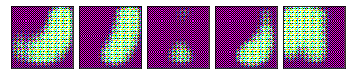

*** Saved checkpoint checkpoints/gan at epoch 24
--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Discriminator loss: 1.462635033270892
Generator loss:     0.6997717794250039


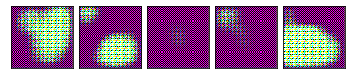

*** Saved checkpoint checkpoints/gan at epoch 25
--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.68it/s]
Discriminator loss: 1.4038803857915543
Generator loss:     0.7226070936988381


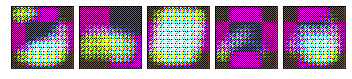

*** Saved checkpoint checkpoints/gan at epoch 26
--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.64it/s]
Discriminator loss: 1.4606272473054773
Generator loss:     0.7221057292293099


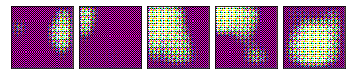

*** Saved checkpoint checkpoints/gan at epoch 27
--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.24it/s]
Discriminator loss: 1.486377379473518
Generator loss:     0.6993611209532794


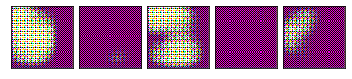

*** Saved checkpoint checkpoints/gan at epoch 28
--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.66it/s]
Discriminator loss: 1.4196072676602531
Generator loss:     0.7149708972257727


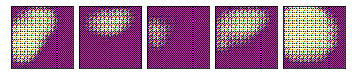

*** Saved checkpoint checkpoints/gan at epoch 29
--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.60it/s]
Discriminator loss: 1.447696279076969
Generator loss:     0.7337861867511973


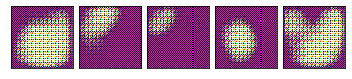

*** Saved checkpoint checkpoints/gan at epoch 30
--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.58it/s]
Discriminator loss: 1.4566352928386015
Generator loss:     0.7219130361781401


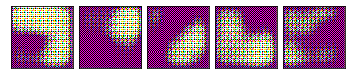

*** Saved checkpoint checkpoints/gan at epoch 31
--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.67it/s]
Discriminator loss: 1.4337418359868668
Generator loss:     0.6846336792497074


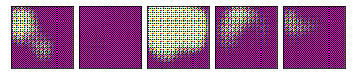

*** Saved checkpoint checkpoints/gan at epoch 32
--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.59it/s]
Discriminator loss: 1.4087794177672441
Generator loss:     0.684738055748098


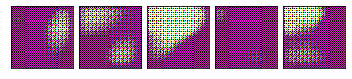

*** Saved checkpoint checkpoints/gan at epoch 33
--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.63it/s]
Discriminator loss: 1.3675856800640331
Generator loss:     0.7427074909210205


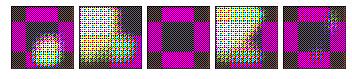

*** Saved checkpoint checkpoints/gan at epoch 34
--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.62it/s]
Discriminator loss: 1.3668404396842508
Generator loss:     0.7315599269726697


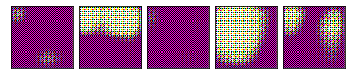

*** Saved checkpoint checkpoints/gan at epoch 35
--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.63it/s]
Discriminator loss: 1.365082926609937
Generator loss:     0.7068461530348834


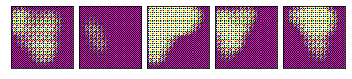

*** Saved checkpoint checkpoints/gan at epoch 36
--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.64it/s]
Discriminator loss: 1.4746565222740173
Generator loss:     0.56147900223732


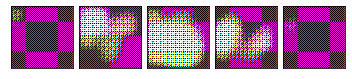

*** Saved checkpoint checkpoints/gan at epoch 37
--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.69it/s]
Discriminator loss: 1.4628041491788977
Generator loss:     0.7347092277863446


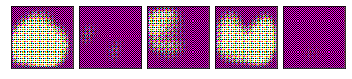

*** Saved checkpoint checkpoints/gan at epoch 38
--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.63it/s]
Discriminator loss: 1.431322455406189
Generator loss:     0.701266769100638


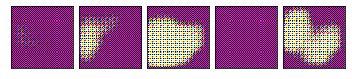

*** Saved checkpoint checkpoints/gan at epoch 39
--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.59it/s]
Discriminator loss: 1.4225682440926046
Generator loss:     0.6685824148795184


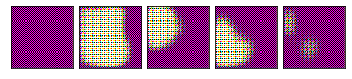

*** Saved checkpoint checkpoints/gan at epoch 40
--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.80it/s]
Discriminator loss: 1.4405577533385332
Generator loss:     0.68858982184354


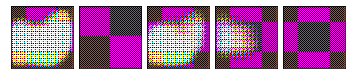

*** Saved checkpoint checkpoints/gan at epoch 41
--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 1.4362907830406637
Generator loss:     0.7305700112791622


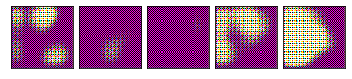

*** Saved checkpoint checkpoints/gan at epoch 42
--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
Discriminator loss: 1.412866290877847
Generator loss:     0.6824072231264675


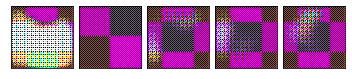

*** Saved checkpoint checkpoints/gan at epoch 43
--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 1.4561455109540153
Generator loss:     0.6602756696588853


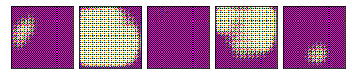

*** Saved checkpoint checkpoints/gan at epoch 44
--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.58it/s]
Discriminator loss: 1.430478439611547
Generator loss:     0.7006824752863716


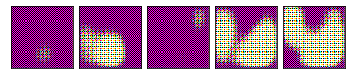

*** Saved checkpoint checkpoints/gan at epoch 45
--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.69it/s]
Discriminator loss: 1.4430584907531738
Generator loss:     0.6946925801389358


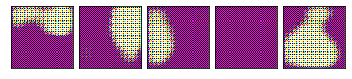

*** Saved checkpoint checkpoints/gan at epoch 46
--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.79it/s]
Discriminator loss: 1.3319680410272934
Generator loss:     0.7089698612689972


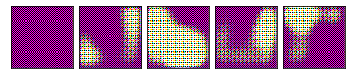

*** Saved checkpoint checkpoints/gan at epoch 47
--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.67it/s]
Discriminator loss: 1.3988441404174357
Generator loss:     0.8119140688110801


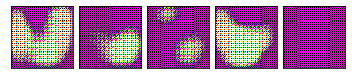

*** Saved checkpoint checkpoints/gan at epoch 48
--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.67it/s]
Discriminator loss: 1.4013077651753145
Generator loss:     0.7247306301313288


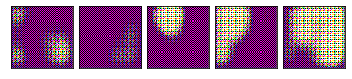

*** Saved checkpoint checkpoints/gan at epoch 49
--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
Discriminator loss: 1.392349734025843
Generator loss:     0.7192029023871702


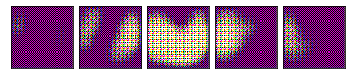

*** Saved checkpoint checkpoints/gan at epoch 50
--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Discriminator loss: 1.4175830798990585
Generator loss:     0.777523093363818


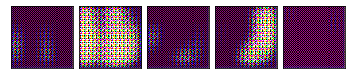

*** Saved checkpoint checkpoints/gan at epoch 51
--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.65it/s]
Discriminator loss: 1.4015027845607084
Generator loss:     0.7024091587347143


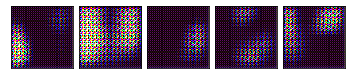

*** Saved checkpoint checkpoints/gan at epoch 52
--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.69it/s]
Discriminator loss: 1.272083983701818
Generator loss:     0.744802886948866


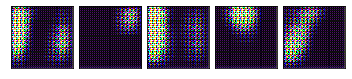

*** Saved checkpoint checkpoints/gan at epoch 53
--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.68it/s]
Discriminator loss: 1.2819085612016565
Generator loss:     0.7026770202552571


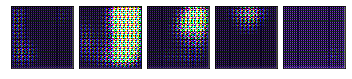

*** Saved checkpoint checkpoints/gan at epoch 54
--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.67it/s]
Discriminator loss: 1.5071621081408333
Generator loss:     0.7781352225471946


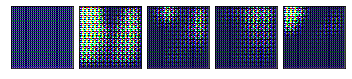

*** Saved checkpoint checkpoints/gan at epoch 55
--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.69it/s]
Discriminator loss: 1.424847876324373
Generator loss:     0.7329338052693535


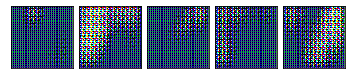

*** Saved checkpoint checkpoints/gan at epoch 56
--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.68it/s]
Discriminator loss: 1.446295086075278
Generator loss:     0.7139420263907489


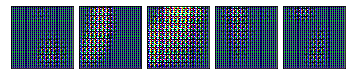

*** Saved checkpoint checkpoints/gan at epoch 57
--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.16it/s]
Discriminator loss: 1.437400824883405
Generator loss:     0.689505596371258


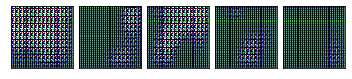

*** Saved checkpoint checkpoints/gan at epoch 58
--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 1.3561441162053276
Generator loss:     0.7445530312902787


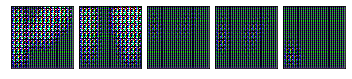

*** Saved checkpoint checkpoints/gan at epoch 59
--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Discriminator loss: 1.3766255659215592
Generator loss:     0.7391162093947915


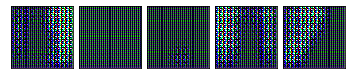

*** Saved checkpoint checkpoints/gan at epoch 60
--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 1.5051318687551163
Generator loss:     0.7628628856995526


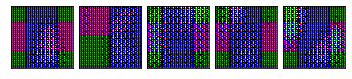

*** Saved checkpoint checkpoints/gan at epoch 61
--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 1.3307934228111715
Generator loss:     0.7961938013048733


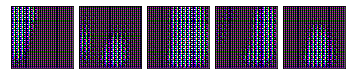

*** Saved checkpoint checkpoints/gan at epoch 62
--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
Discriminator loss: 1.4843140279545504
Generator loss:     0.7447896108907812


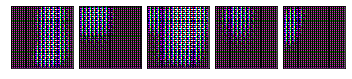

*** Saved checkpoint checkpoints/gan at epoch 63
--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Discriminator loss: 1.410620605244356
Generator loss:     0.7203725628993091


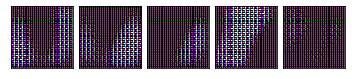

*** Saved checkpoint checkpoints/gan at epoch 64
--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 1.4345108551137589
Generator loss:     0.696312790407854


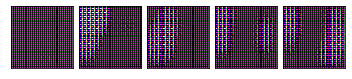

*** Saved checkpoint checkpoints/gan at epoch 65
--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.09it/s]
Discriminator loss: 1.4560975818073048
Generator loss:     0.7442949870053459


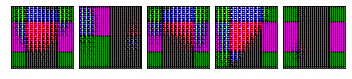

*** Saved checkpoint checkpoints/gan at epoch 66
--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Discriminator loss: 1.416592885466183
Generator loss:     0.7250774958554436


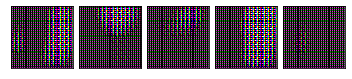

*** Saved checkpoint checkpoints/gan at epoch 67
--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 1.3271256545010734
Generator loss:     0.7439037929562962


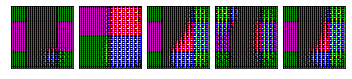

*** Saved checkpoint checkpoints/gan at epoch 68
--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Discriminator loss: 1.3755588566555697
Generator loss:     0.6907376243787653


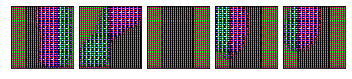

*** Saved checkpoint checkpoints/gan at epoch 69
--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 1.50456306513618
Generator loss:     0.7035363702213063


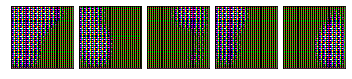

*** Saved checkpoint checkpoints/gan at epoch 70
--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.72it/s]
Discriminator loss: 1.4123738513273352
Generator loss:     0.676973704029532


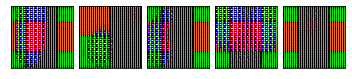

*** Saved checkpoint checkpoints/gan at epoch 71
--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.62it/s]
Discriminator loss: 1.424068289644578
Generator loss:     0.691476401160745


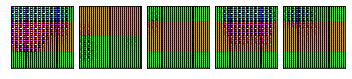

*** Saved checkpoint checkpoints/gan at epoch 72
--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.64it/s]
Discriminator loss: 1.4442602956996244
Generator loss:     0.7002556429189795


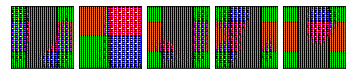

*** Saved checkpoint checkpoints/gan at epoch 73
--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 1.4095018751481
Generator loss:     0.6657600683324477


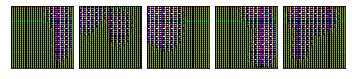

*** Saved checkpoint checkpoints/gan at epoch 74
--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.01it/s]
Discriminator loss: 1.4347261611153097
Generator loss:     0.7168522582334631


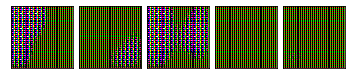

*** Saved checkpoint checkpoints/gan at epoch 75
--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.67it/s]
Discriminator loss: 1.3983158574384802
Generator loss:     0.7429195607409758


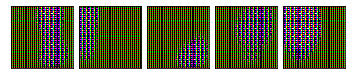

*** Saved checkpoint checkpoints/gan at epoch 76
--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.67it/s]
Discriminator loss: 1.425653289346134
Generator loss:     0.7444080500041738


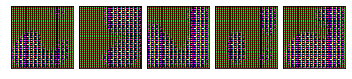

*** Saved checkpoint checkpoints/gan at epoch 77
--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.63it/s]
Discriminator loss: 1.3978738434174482
Generator loss:     0.7357333372620976


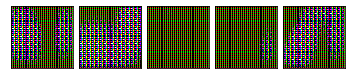

*** Saved checkpoint checkpoints/gan at epoch 78
--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.64it/s]
Discriminator loss: 1.4032782316207886
Generator loss:     0.7091313845971051


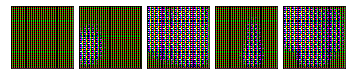

*** Saved checkpoint checkpoints/gan at epoch 79
--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.67it/s]
Discriminator loss: 1.447680950164795
Generator loss:     0.7226719084907981


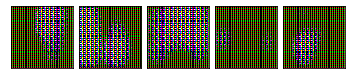

*** Saved checkpoint checkpoints/gan at epoch 80
--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.73it/s]
Discriminator loss: 1.4068198484532974
Generator loss:     0.6879788602099699


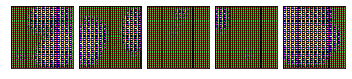

*** Saved checkpoint checkpoints/gan at epoch 81
--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.14it/s]
Discriminator loss: 1.3899920617832857
Generator loss:     0.7546717980328728


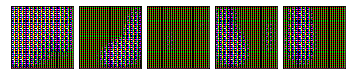

*** Saved checkpoint checkpoints/gan at epoch 82
--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.44it/s]
Discriminator loss: 1.4465233227785896
Generator loss:     0.7395283229210797


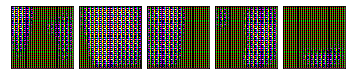

*** Saved checkpoint checkpoints/gan at epoch 83
--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.17it/s]
Discriminator loss: 1.4028884102316463
Generator loss:     0.7199042579706978


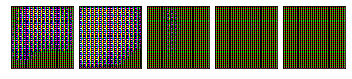

*** Saved checkpoint checkpoints/gan at epoch 84
--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.21it/s]
Discriminator loss: 1.3446560256621416
Generator loss:     0.6551585811025956


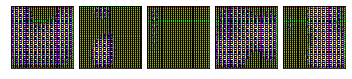

*** Saved checkpoint checkpoints/gan at epoch 85
--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.18it/s]
Discriminator loss: 1.3019269073710722
Generator loss:     0.8073466420173645


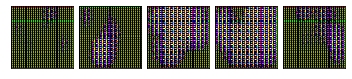

*** Saved checkpoint checkpoints/gan at epoch 86
--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.14it/s]
Discriminator loss: 1.390881275429445
Generator loss:     0.7686603875721202


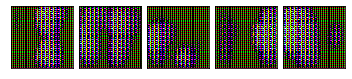

*** Saved checkpoint checkpoints/gan at epoch 87
--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.73it/s]
Discriminator loss: 1.4606659622753368
Generator loss:     0.7195883954272551


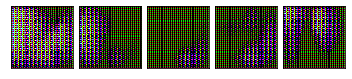

*** Saved checkpoint checkpoints/gan at epoch 88
--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.72it/s]
Discriminator loss: 1.4078405744889204
Generator loss:     0.7032484867993523


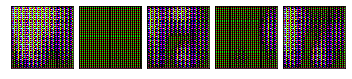

*** Saved checkpoint checkpoints/gan at epoch 89
--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.71it/s]
Discriminator loss: 1.3511458565207088
Generator loss:     0.7033910856527441


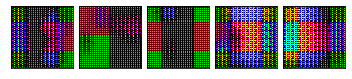

*** Saved checkpoint checkpoints/gan at epoch 90
--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.74it/s]
Discriminator loss: 1.3465120301527136
Generator loss:     0.774674184182111


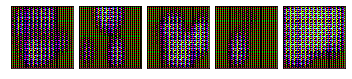

*** Saved checkpoint checkpoints/gan at epoch 91
--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.87it/s]
Discriminator loss: 1.4012111215030445
Generator loss:     0.7110906068016501


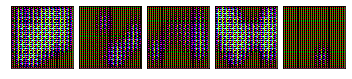

*** Saved checkpoint checkpoints/gan at epoch 92
--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.18it/s]
Discriminator loss: 1.3679107848335714
Generator loss:     0.6970525068395278


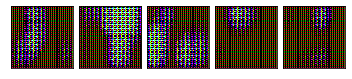

*** Saved checkpoint checkpoints/gan at epoch 93
--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.16it/s]
Discriminator loss: 1.4721827577142155
Generator loss:     0.6604954389964833


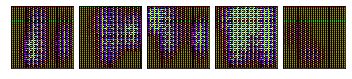

*** Saved checkpoint checkpoints/gan at epoch 94
--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.23it/s]
Discriminator loss: 1.419073925298803
Generator loss:     0.6918808923048132


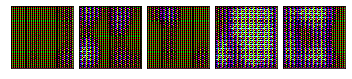

*** Saved checkpoint checkpoints/gan at epoch 95
--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.22it/s]
Discriminator loss: 1.3647093352149515
Generator loss:     0.6669281791238224


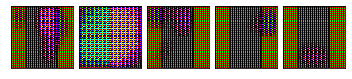

*** Saved checkpoint checkpoints/gan at epoch 96
--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.19it/s]
Discriminator loss: 1.4388149906607235
Generator loss:     0.7324533848201528


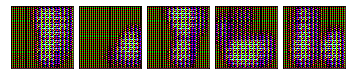

*** Saved checkpoint checkpoints/gan at epoch 97
--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.20it/s]
Discriminator loss: 1.4052042680628158
Generator loss:     0.7075241909307592


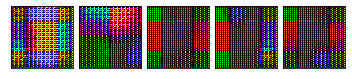

*** Saved checkpoint checkpoints/gan at epoch 98
--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.19it/s]
Discriminator loss: 1.4201320760390337
Generator loss:     0.6781334421213936


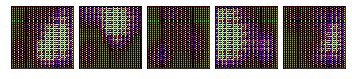

*** Saved checkpoint checkpoints/gan at epoch 99
--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.19it/s]
Discriminator loss: 1.416434645652771
Generator loss:     0.6901359908721026


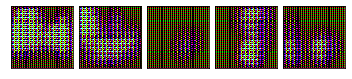

*** Saved checkpoint checkpoints/gan at epoch 100


In [12]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)
    torch.save(gen, checkpoint_file)
    print(f'*** Saved checkpoint {checkpoint_file} '
          f'at epoch {epoch_idx+1}')
    hp['data_label'] = 1 - hp['data_label']


*** Images Generated from best model:


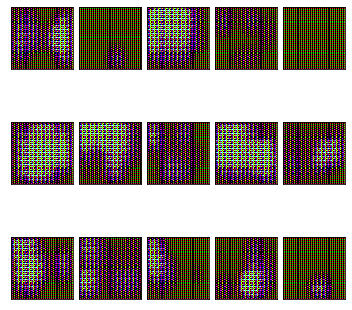

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [14]:
from cs236605.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [15]:
display_answer(hw3.answers.part3_q1)


**We will sometimes discard the gradients for the sampling** 

When we want to train the discriminator, and not the generator.
If we do not Do it so, we wil not discard the gradients after the backprop was preformed on
the loss of the discriminator, they will impact the training of the generator, and we don't want that.
We want the generator's gradients to be affected only by it's loss, and not the discriminator's.



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [16]:
display_answer(hw3.answers.part3_q2)

### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [17]:
display_answer(hw3.answers.part3_q3)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

